In [28]:
import matplotlib.pyplot as plt
import numpy as np

In [29]:
import importlib

import endoutbreakvbd
import endoutbreakvbd.chikungunya
import endoutbreakvbd.eop
import endoutbreakvbd.inference
import endoutbreakvbd.model
import endoutbreakvbd.utils

importlib.reload(endoutbreakvbd.model)
importlib.reload(endoutbreakvbd.eop)
importlib.reload(endoutbreakvbd.chikungunya)
importlib.reload(endoutbreakvbd.inference)
importlib.reload(endoutbreakvbd.utils)
importlib.reload(endoutbreakvbd)

from endoutbreakvbd.chikungunya import get_data, get_parameters, get_weather_data
from endoutbreakvbd.inference import fit_random_walk_model

In [30]:
df = get_data()
df_weather = get_weather_data()
parameters = get_parameters()
gen_time_dist_vec = parameters["gen_time_dist_vec"]

rng = np.random.default_rng(2)

In [31]:
doy_start = df["doy"].to_numpy()[0]
incidence_vec = np.append(
    df["cases"].to_numpy(), np.zeros(len(gen_time_dist_vec) + 1, dtype=int)
)
no_days = len(incidence_vec)
t_vec = np.arange(no_days)
doy_vec = (np.arange(doy_start, doy_start + no_days) - 1) % 365 + 1
temperature_vec = (
    df_weather["temperature"].loc[df_weather["doy"].isin(doy_vec)].to_numpy()
)
temperature_vec_smoothed = (
    df_weather["temperature_smoothed"].loc[df_weather["doy"].isin(doy_vec)].to_numpy()
)
temperature_vec_rolling = (
    df_weather["temperature_rolling"].loc[df_weather["doy"].isin(doy_vec)].to_numpy()
)
suitability_vec = (
    df_weather["suitability"].loc[df_weather["doy"].isin(doy_vec)].to_numpy()
)
suitability_vec_smoothed = (
    df_weather["suitability_smoothed"].loc[df_weather["doy"].isin(doy_vec)].to_numpy()
)
suitability_vec_rolling = (
    df_weather["suitability_rolling_temp"]
    .loc[df_weather["doy"].isin(doy_vec)]
    .to_numpy()
)

In [32]:
idata = fit_random_walk_model(
    incidence_vec=incidence_vec,
    gen_time_dist_vec=gen_time_dist_vec,
    random_walk_sd=0.1,
)
rep_no_vec = idata.posterior["rep_no_vec"].mean(dim=["chain", "draw"]).to_numpy()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rep_no_start, rep_no_jumps]


Output()

/Users/user/Documents/Git_repos/end-of-outbreak-vbd/.pixi/envs/default/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


np.float64(0.8876176760678097)

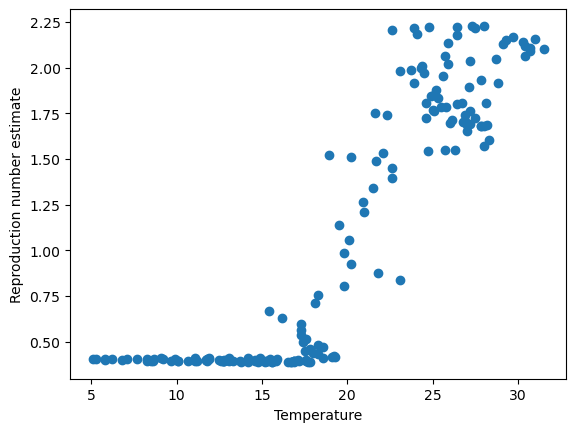

In [33]:
fig, ax = plt.subplots()
ax.scatter(temperature_vec, rep_no_vec)
ax.set_xlabel("Temperature")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(temperature_vec, rep_no_vec)[0, 1]

np.float64(0.9118729134316359)

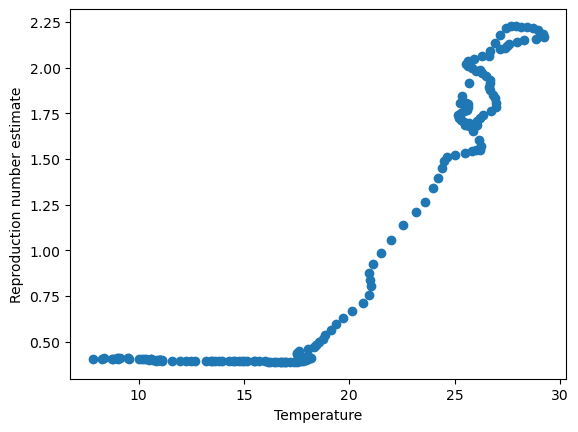

In [34]:
fig, ax = plt.subplots()
ax.scatter(temperature_vec_rolling, rep_no_vec)
ax.set_xlabel("Temperature")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(temperature_vec_rolling, rep_no_vec)[0, 1]

np.float64(0.8709494414391924)

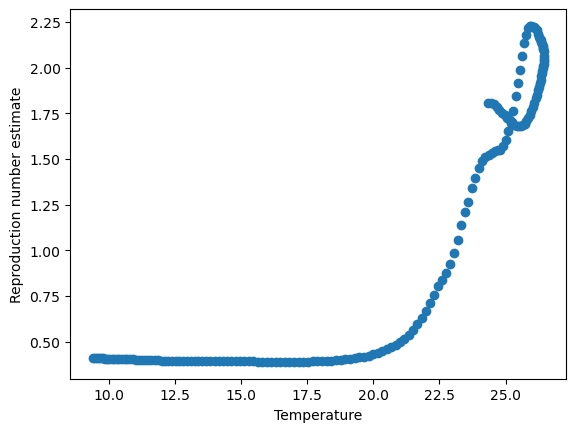

In [35]:
fig, ax = plt.subplots()
ax.scatter(temperature_vec_smoothed, rep_no_vec)
ax.set_xlabel("Temperature")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(temperature_vec_smoothed, rep_no_vec)[0, 1]

np.float64(0.7792807244305927)

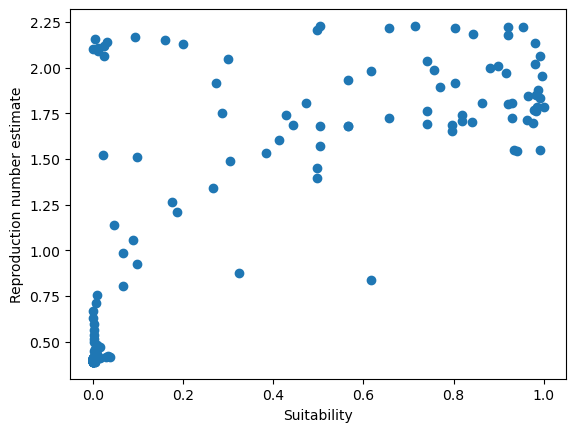

In [36]:
fig, ax = plt.subplots()
ax.scatter(suitability_vec, rep_no_vec)
ax.set_xlabel("Suitability")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(suitability_vec, rep_no_vec)[0, 1]

np.float64(0.8690915658725179)

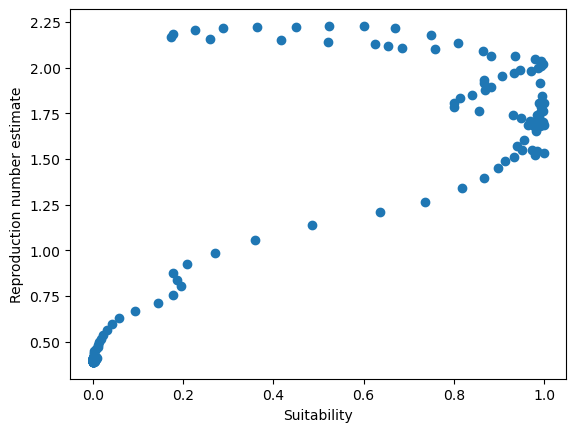

In [37]:
fig, ax = plt.subplots()
ax.scatter(suitability_vec_rolling, rep_no_vec)
ax.set_xlabel("Suitability")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(suitability_vec_rolling, rep_no_vec)[0, 1]

np.float64(0.9700194562026275)

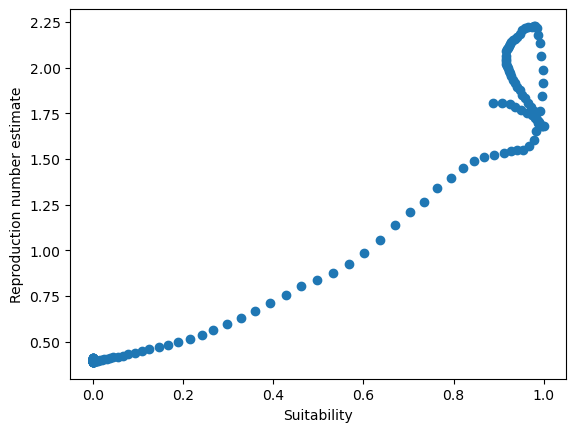

In [38]:
fig, ax = plt.subplots()
ax.scatter(suitability_vec_smoothed, rep_no_vec)
ax.set_xlabel("Suitability")
ax.set_ylabel("Reproduction number estimate")
np.corrcoef(suitability_vec_smoothed, rep_no_vec)[0, 1]